# Model to Predict Future Prices of different Neighbourhood in Toronto

## Importing all Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import datetime
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.cluster import KMeans
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# create a Graphviz file
from sklearn.tree import export_graphviz
from IPython.display import Image

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium  # map rendering library

import time

print("Libraries imported.")

Libraries imported.


## Importing all the Data from Excel or CSV Files

In [2]:
canada_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\Canada.xlsx')
cpi_ontario_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\cpi_ontario.csv')
gta_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\GTA.csv')
income_age_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\household_income_by_age_2000_2018.csv')
income_family_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\household_income_by_family_type_2000_2018.csv')
hpi_house_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\hpi_by_housing_type_2005_2021.csv')
primary_rate_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\primary_rate_canada.csv')
neigh_census_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\toronto_neighbourhoods_census_data.csv')
neigh_coordinates_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\toronto_neighbourhoods_coordinates.csv')
neigh_hist_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\toronto_neighbourhoods_historical_data.csv')
neigh_hist_people_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\toronto_neighbourhoods_historical_people_data.csv')
unemployment_rate_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\unemployment_rate_age15to64_ontario.csv')
yearly_macro_pct_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\yearly_macro_variables_changing_pct_summary.csv')
macro_var_summary_data = Path(r'C:\Users\Office\Desktop\Project1-main\Data\yearly_macro_variables_summary.csv')

In [3]:
canada = pd.read_excel(canada_data,  parse_dates = True)
cpi_ontario = pd.read_csv(cpi_ontario_data, parse_dates = True)
gta = pd.read_csv(gta_data, parse_dates = True)
income_age = pd.read_csv(income_age_data, parse_dates = True)
income_family = pd.read_csv(income_family_data, parse_dates = True)
hpi_house = pd.read_csv(hpi_house_data, parse_dates = True)
primary_rate = pd.read_csv(primary_rate_data, parse_dates = True)
neigh_census = pd.read_csv(neigh_census_data, parse_dates = True)
neigh_coordinates = pd.read_csv(neigh_coordinates_data, parse_dates = True)
neigh_hist = pd.read_csv(neigh_hist_data, parse_dates = True)
neigh_hist_people = pd.read_csv(neigh_hist_people_data, parse_dates = True)
unemploy_rate = pd.read_csv(unemployment_rate_data, parse_dates = True)
yearly_macro_pct = pd.read_csv(yearly_macro_pct_data, parse_dates = True)
macro_var_summary = pd.read_csv(macro_var_summary_data, parse_dates = True)

## Cleaning up all data for analysis

In [4]:
neigh_hist.head()
neigh_hist_d1 = neigh_hist.melt(id_vars = 'neighbourhood')
neigh_hist_d1.rename(columns = {'variable' : 'year'}, inplace = True)
neigh_hist_d1 = neigh_hist_d1[['year', 'neighbourhood', 'value']].drop_duplicates()
neigh_hist_d1.head()

,year,neighbourhood,value
0,2001,Agincourt North,200388
1,2001,Agincourt South-Malvern West,203047
2,2001,Alderwood,259998
3,2001,Annex,453850
4,2001,Banbury-Don Mills,371864


In [5]:
# Calculating Average house prices based on different categories of houses
gta['year'] = pd.DatetimeIndex(gta['Date']).year
gta = gta[['year', 'Composite_Benchmark_SA', 'Single_Family_Benchmark_SA', 'One_Storey_Benchmark_SA', 'Two_Storey_Benchmark_SA', 'Townhouse_Benchmark_SA', 'Apartment_Benchmark_SA']]
gta_avg = gta.groupby('year').mean()
gta_avg.reset_index(inplace = True)
gta_avg.head()

,year,Composite_Benchmark_SA,Single_Family_Benchmark_SA,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA
0,2005,316133.333333,360750.000000,317725.000000,375683.333333,220675.000000,203275.0
1,2006,331933.333333,379333.333333,334600.000000,394941.666667,230808.333333,212800.0
2,2007,350925.000000,401175.000000,353375.000000,417808.333333,242425.000000,225575.0
3,2008,363975.000000,412450.000000,361291.666667,430341.666667,251141.666667,240875.0
4,2009,365091.666667,412016.666667,357625.000000,431108.333333,250550.000000,244825.0


## Consolidating all variables into one Dataset at a yearly basis

In [6]:
var_consolidation = pd.merge(left = gta_avg, right = macro_var_summary, how = 'inner', left_on = 'year', right_on = 'Year')
var_consolidation.drop(columns = 'Year', inplace = True)
var_consolidation.head()

,year,Composite_Benchmark_SA,Single_Family_Benchmark_SA,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA,Consumer Price Index (CPI),Household Income,Prime Rate,Unemployment Rate,House Price Index (HPI),Benchmark Housing Value
0,2005,316133.333333,360750.000000,317725.000000,375683.333333,220675.000000,203275.0,106.88,61800.0,4.42,6.72,102.31,316133.33
1,2006,331933.333333,379333.333333,334600.000000,394941.666667,230808.333333,212800.0,108.77,63800.0,5.81,6.39,107.43,331933.33
2,2007,350925.000000,401175.000000,353375.000000,417808.333333,242425.000000,225575.0,110.76,66560.0,6.10,6.49,113.57,350925.00
3,2008,363975.000000,412450.000000,361291.666667,430341.666667,251141.666667,240875.0,113.28,68120.0,4.73,6.67,117.79,363975.00
4,2009,365091.666667,412016.666667,357625.000000,431108.333333,250550.000000,244825.0,113.70,66790.0,2.40,9.27,118.15,365091.67


In [7]:
# Setting up dataframe based on year to merge with another dataset
primary_rate['year'] = pd.DatetimeIndex(primary_rate['Date']).year
primary_rate = primary_rate[['year', 'Prime Rate', 'Bank of Canada Overnight Rate']]
primary_rate_df = primary_rate.groupby('year').mean()
primary_rate_df.head()

,Prime Rate,Bank of Canada Overnight Rate
year,,
2000,7.270833,4.833333
2001,5.812500,4.062500
2002,4.208333,2.458333
2003,4.687500,2.937500
2004,4.000000,2.250000


## Grouping All Datasets into one

In [8]:
# Merge the coordinates based on the neighbourhood
neighbourhood_census_coordinates = pd.merge(left = neigh_census, right = neigh_coordinates, how = 'inner', left_on = 'neighbourhood', right_on = 'neighbourhood')
# merge the bank rate with the above dataset
neigh_data_bank_rate = pd.merge(left = neighbourhood_census_coordinates, right = primary_rate_df, how = 'inner', left_on = 'year', right_on = 'year')
# bringing in historical Prices based on neighbourhood
neigh_data_bank_rate['year'] = neigh_data_bank_rate.year.astype(object)
# bringing variables into the overall dataset
df_consolidation = pd.merge(left = neigh_data_bank_rate, right = var_consolidation, how = 'inner', left_on = 'year', right_on = 'year')
list_of_columns = df_consolidation.columns
df_consolidation.head()

,year,neighbourhood,single_detached_house,apartment_five_storeys_plus,movable_dwelling,semi_detached_house,row_house,duplex,apartment_five_storeys_less,other_house,...,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA,Consumer Price Index (CPI),Household Income,Prime Rate_y,Unemployment Rate,House Price Index (HPI),Benchmark Housing Value
0,2006,Agincourt North,3295,2060,0,775,1425,600,565,0,...,334600.0,394941.666667,230808.333333,212800.0,108.77,63800.0,5.81,6.39,107.43,331933.33
1,2006,Agincourt South-Malvern West,2695,1840,5,305,420,610,860,5,...,334600.0,394941.666667,230808.333333,212800.0,108.77,63800.0,5.81,6.39,107.43,331933.33
2,2006,Alderwood,2750,315,5,480,85,370,540,5,...,334600.0,394941.666667,230808.333333,212800.0,108.77,63800.0,5.81,6.39,107.43,331933.33
3,2006,Annex,630,7135,0,1120,620,240,4955,15,...,334600.0,394941.666667,230808.333333,212800.0,108.77,63800.0,5.81,6.39,107.43,331933.33
4,2006,Banbury-Don Mills,3620,5020,5,285,660,30,1330,0,...,334600.0,394941.666667,230808.333333,212800.0,108.77,63800.0,5.81,6.39,107.43,331933.33


## Limiting the dataset to the most recent year

In [9]:
df_consolidation.groupby(['year', 'neighbourhood']).mean()
df_consolidation.sort_values(['year','average_house_value'], ascending = [True, False], inplace = True)
df_consolidation.tail()

,year,neighbourhood,single_detached_house,apartment_five_storeys_plus,movable_dwelling,semi_detached_house,row_house,duplex,apartment_five_storeys_less,other_house,...,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA,Consumer Price Index (CPI),Household Income,Prime Rate_y,Unemployment Rate,House Price Index (HPI),Benchmark Housing Value
353,2016,Malvern,3475,3175,0,1275,3540,1220,655,85,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
398,2016,Thorncliffe Park,0,6660,0,0,85,0,375,0,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
361,2016,Mount Olive-Silverstone-Jamestown,1655,6165,0,160,1040,755,90,0,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
395,2016,Taylor-Massey,600,4840,0,195,185,195,240,25,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
322,2016,Flemingdon Park,0,6425,0,180,565,5,645,0,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0


In [10]:
year_list = []
for x in df_consolidation['year'].sort_values():
    if x not in year_list:
        year_list.append(x)

recent_year = year_list[-1]

In [11]:
latest_df = df_consolidation[df_consolidation['year'] == recent_year]
latest_df

,year,neighbourhood,single_detached_house,apartment_five_storeys_plus,movable_dwelling,semi_detached_house,row_house,duplex,apartment_five_storeys_less,other_house,...,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA,Consumer Price Index (CPI),Household Income,Prime Rate_y,Unemployment Rate,House Price Index (HPI),Benchmark Housing Value
296,2016,Bridle Path-Sunnybrook-York Mills,2275,590,0,40,230,30,80,0,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
324,2016,Forest Hill South,1685,2025,0,65,40,70,1050,0,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
349,2016,Lawrence Park South,3420,925,0,110,35,230,1015,5,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
384,2016,Rosedale-Moore Park,2450,4990,0,485,260,345,1505,5,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
391,2016,St.Andrew-Windfields,3245,1745,0,175,540,120,595,5,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,2016,Malvern,3475,3175,0,1275,3540,1220,655,85,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
398,2016,Thorncliffe Park,0,6660,0,0,85,0,375,0,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
361,2016,Mount Olive-Silverstone-Jamestown,1655,6165,0,160,1040,755,90,0,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0
395,2016,Taylor-Massey,600,4840,0,195,185,195,240,25,...,684833.333333,819775.0,435000.0,359575.0,129.68,80310.0,2.7,6.74,210.92,651750.0


## Creating Cooefficient Matrix

In [12]:
dataset_cols = list(latest_df)
cols = []
for x in dataset_cols:
    if x not in ['year', 'neighbourhood', 'lat', 'lon']:
        cols.append(x)
        
        
list(cols)
coef = np.corrcoef(latest_df[cols].values.T)
coef_matrix = pd.DataFrame(coef, columns = cols, index = cols)
coef_matrix.head()

C:\Users\Office\.conda\envs\dev\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Office\.conda\envs\dev\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,single_detached_house,apartment_five_storeys_plus,movable_dwelling,semi_detached_house,row_house,duplex,apartment_five_storeys_less,other_house,average_house_value,shelter_costs_owned,...,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA,Consumer Price Index (CPI),Household Income,Prime Rate_y,Unemployment Rate,House Price Index (HPI),Benchmark Housing Value
single_detached_house,1.000000,-0.153199,0.064259,-0.081730,0.209109,0.495530,-0.162663,-0.115848,0.076087,-0.100503,...,-1.335543e-16,NaN,NaN,NaN,-1.335543e-16,NaN,1.335543e-16,-1.335543e-16,-1.335543e-16,NaN
apartment_five_storeys_plus,-0.153199,1.000000,-0.082457,-0.208599,0.147607,-0.114219,-0.013098,-0.046362,-0.149417,0.124604,...,3.445062e-17,NaN,NaN,NaN,3.445062e-17,NaN,-3.445062e-17,3.445062e-17,3.445062e-17,NaN
movable_dwelling,0.064259,-0.082457,1.000000,0.142440,0.027792,0.146691,0.220564,0.019601,-0.082996,-0.076312,...,-6.804816e-18,NaN,NaN,NaN,-6.804816e-18,NaN,6.804816e-18,-6.804816e-18,-6.804816e-18,NaN
semi_detached_house,-0.081730,-0.208599,0.142440,1.000000,0.309624,0.184273,0.421881,0.241908,-0.074948,-0.066279,...,-1.106683e-16,NaN,NaN,NaN,-1.106683e-16,NaN,1.106683e-16,-1.106683e-16,-1.106683e-16,NaN
row_house,0.209109,0.147607,0.027792,0.309624,1.000000,0.368666,0.083693,0.212898,-0.286759,-0.217666,...,0.000000e+00,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN


### Remove Outliers

In [13]:
useful_variables = coef_matrix[abs(coef_matrix.average_house_value) > 0.01].index
useful_variables = list(useful_variables)

In [14]:
useful_variables

['single_detached_house',
 'apartment_five_storeys_plus',
 'movable_dwelling',
 'semi_detached_house',
 'row_house',
 'duplex',
 'apartment_five_storeys_less',
 'average_house_value',
 'shelter_costs_owned',
 'shelter_costs_rented']

## Cluster Distribution at different location

In [15]:
df_clusters = latest_df.loc[ :, useful_variables + ['lat', 'lon']]

# Standard processing
sc = StandardScaler()
df_clusters_standard = sc.fit_transform(df_clusters)
df_clusters_standard = pd.DataFrame(df_clusters_standard)
df_clusters_standard.columns = df_clusters.columns
df_clusters_standard.head()

,single_detached_house,apartment_five_storeys_plus,movable_dwelling,semi_detached_house,row_house,duplex,apartment_five_storeys_less,average_house_value,shelter_costs_owned,shelter_costs_rented,lat,lon
0,0.247205,-0.648155,-0.291139,-0.829328,-0.413617,-1.002885,-0.998938,5.110507,3.649487,6.252381,0.433982,0.209299
1,-0.171049,-0.331077,-0.291139,-0.785080,-0.788288,-0.876352,-0.120196,3.500992,1.987267,0.851905,-0.280183,-0.138990
2,1.058901,-0.574133,-0.291139,-0.705434,-0.798148,-0.370221,-0.151903,3.004418,2.821573,0.959469,0.163847,-0.057572
3,0.371264,0.324069,-0.291139,-0.041719,-0.354458,-0.006440,0.291997,3.002532,2.354873,2.049950,-0.509290,0.201773
4,0.934843,-0.392946,-0.291139,-0.590390,0.197688,-0.718186,-0.532389,2.542151,2.412411,1.144925,0.927860,0.207992


In [16]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters_standard)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
df_clusters_standard.insert(0, "Cluster Labels", kmeans.labels_)
df_clusters_standard

,Cluster Labels,single_detached_house,apartment_five_storeys_plus,movable_dwelling,semi_detached_house,row_house,duplex,apartment_five_storeys_less,average_house_value,shelter_costs_owned,shelter_costs_rented,lat,lon
0,2,0.247205,-0.648155,-0.291139,-0.829328,-0.413617,-1.002885,-0.998938,5.110507,3.649487,6.252381,0.433982,0.209299
1,2,-0.171049,-0.331077,-0.291139,-0.785080,-0.788288,-0.876352,-0.120196,3.500992,1.987267,0.851905,-0.280183,-0.138990
2,2,1.058901,-0.574133,-0.291139,-0.705434,-0.798148,-0.370221,-0.151903,3.004418,2.821573,0.959469,0.163847,-0.057572
3,2,0.371264,0.324069,-0.291139,-0.041719,-0.354458,-0.006440,0.291997,3.002532,2.354873,2.049950,-0.509290,0.201773
4,2,0.934843,-0.392946,-0.291139,-0.590390,0.197688,-0.718186,-0.532389,2.542151,2.412411,1.144925,0.927860,0.207992
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,4,1.097891,-0.076973,-0.291139,1.356507,6.113545,2.761463,-0.478034,-1.072523,-0.509260,-0.283085,1.855858,1.747351
136,0,-1.365553,0.693073,-0.291139,-0.900124,-0.699550,-1.097784,-0.731691,-1.080388,-0.231158,0.162009,-0.021361,0.493729
137,0,-0.192316,0.583697,-0.291139,-0.616939,1.183664,1.290521,-0.989878,-1.090532,-0.812935,-0.449995,0.744304,-1.839847
138,0,-0.940210,0.290925,-0.291139,-0.554992,-0.502355,-0.480937,-0.853991,-1.157585,-0.921619,-0.628033,-0.270936,1.025624


In [17]:
# import matplotlib.cm as cm
# create map
lat = 43.6532
lon = -79.3832
map_clusters = folium.Map(location=[lat, lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
    df_clusters["lat"],
    df_clusters["lon"],
    df_clusters_standard["average_house_value"],
    df_clusters_standard["Cluster Labels"],
):
    label = folium.Popup(str(poi) + " Cluster " + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7,
    ).add_to(map_clusters)

map_clusters

## Use Seaborn to plot heatmap

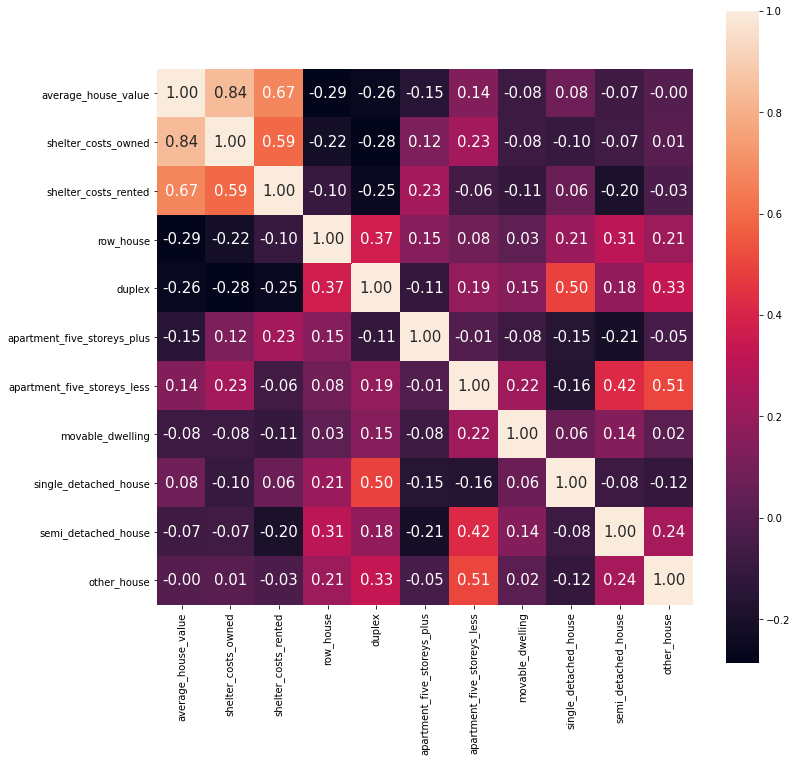

In [18]:
cols = coef_matrix.iloc[(-np.abs(coef_matrix["average_house_value"].values)).argsort()].index[:11]

coef = np.corrcoef(latest_df[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    coef,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)

## Plot Scatter_matrix

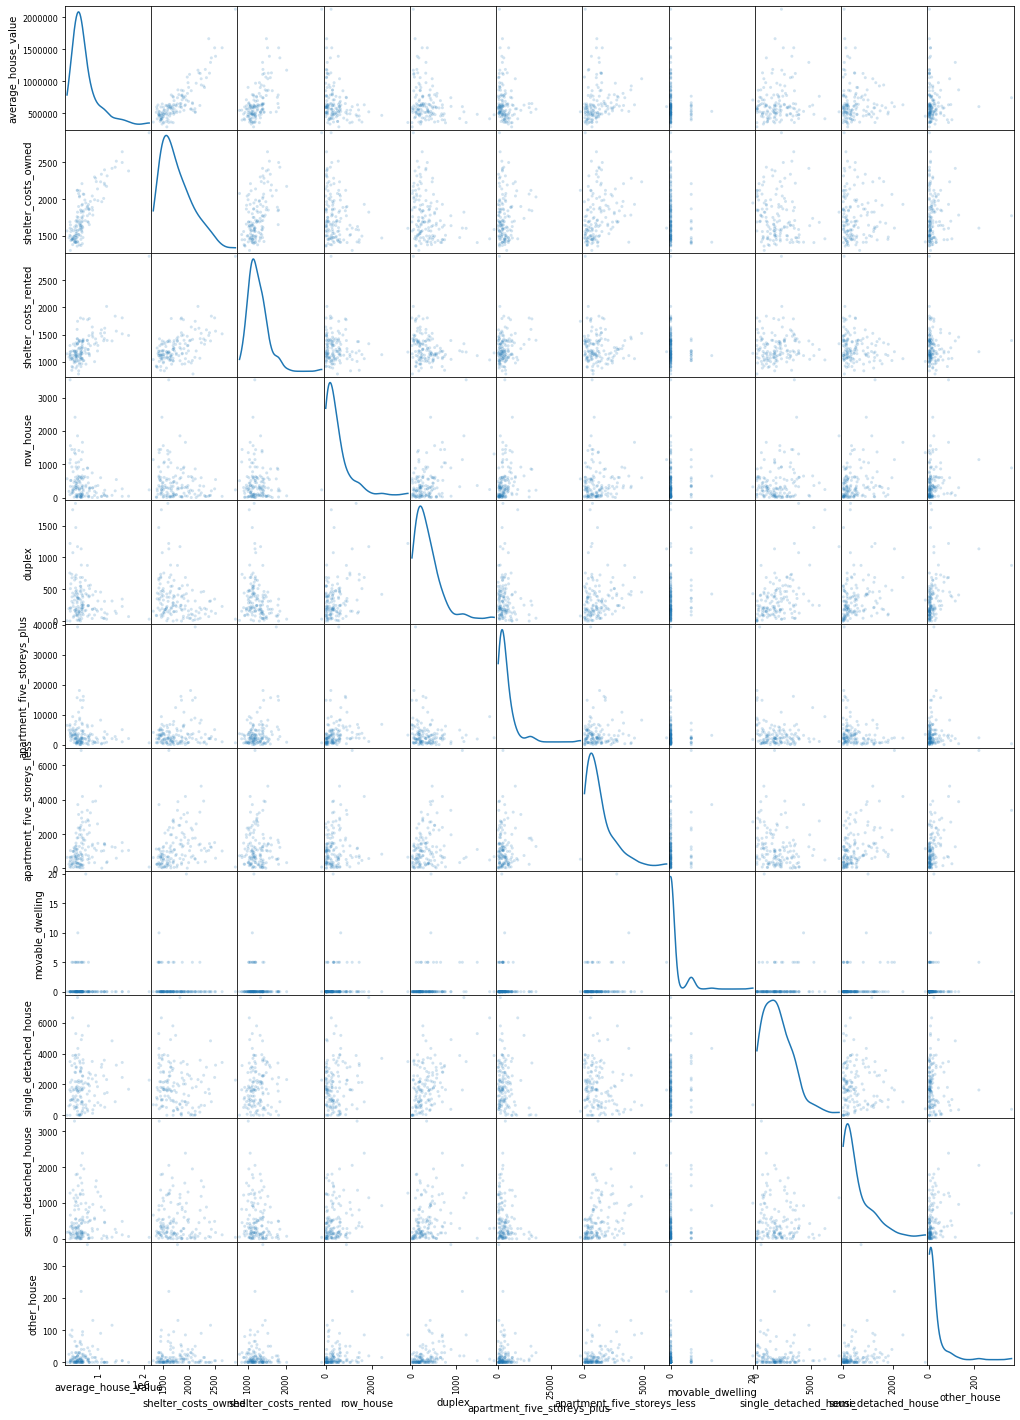

In [19]:
cols = coef_matrix.iloc[(-np.abs(coef_matrix["average_house_value"].values)).argsort()].index[:11]
scatter_matrix = scatter_matrix(
    latest_df[cols], alpha=0.2, figsize=(17, 25), diagonal="kde"
)

## Producing some Bar Graphs

In [20]:
temp = latest_df
temp["price_binned"] = pd.qcut(
    temp["average_house_value"], 5, labels=["very low", "low", "medium", "high", "very high"]
)
temp.price_binned.value_counts()

C:\Users\Office\.conda\envs\dev\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


very low     28
low          28
medium       28
high         28
very high    28
Name: price_binned, dtype: int64

In [21]:
list(cols)

['average_house_value',
 'shelter_costs_owned',
 'shelter_costs_rented',
 'row_house',
 'duplex',
 'apartment_five_storeys_plus',
 'apartment_five_storeys_less',
 'movable_dwelling',
 'single_detached_house',
 'semi_detached_house',
 'other_house']

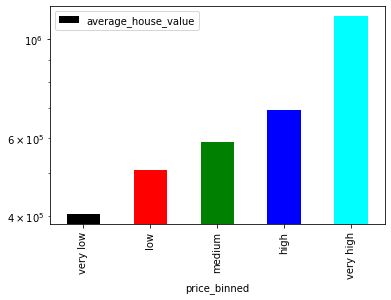

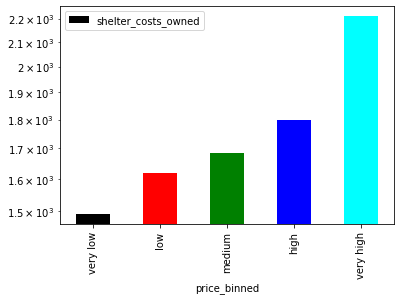

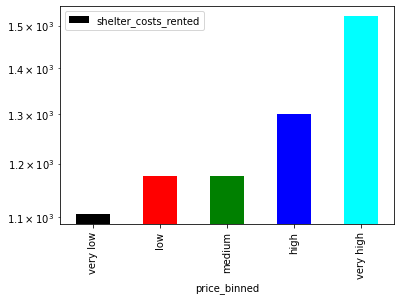

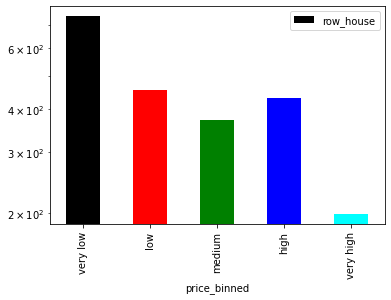

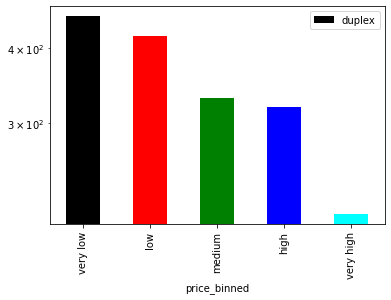

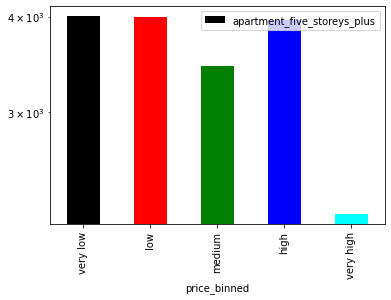

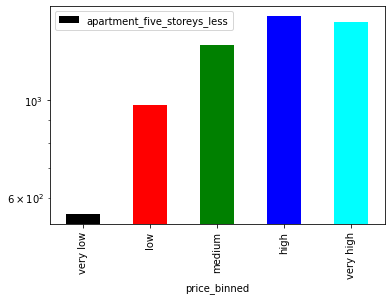

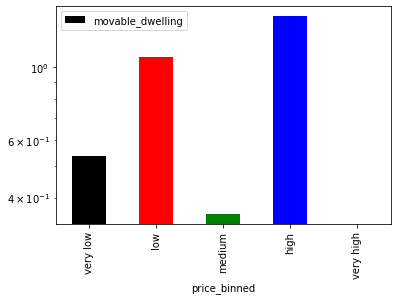

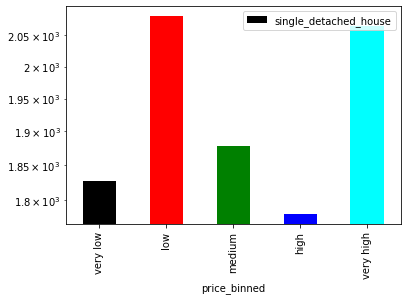

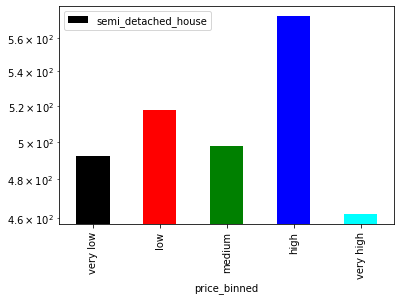

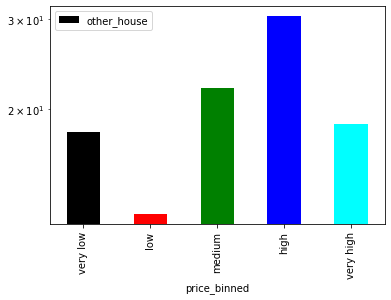

In [22]:
for feature in cols:
    temp.loc[:, ["price_binned", feature]].groupby(
        "price_binned"
    ).mean().reset_index().plot.bar(x="price_binned", y=feature, logy=True, color = ['black', 'red', 'green', 'blue', 'cyan'])

In [23]:
# setting up variables
feature_1 = []
for x in useful_variables:
    if 'average_house_value' not in x:
        feature_1.append(x)
feature_1

['single_detached_house',
 'apartment_five_storeys_plus',
 'movable_dwelling',
 'semi_detached_house',
 'row_house',
 'duplex',
 'apartment_five_storeys_less',
 'shelter_costs_owned',
 'shelter_costs_rented']

In [24]:
# Create features and label
useful_features_1 = feature_1
X = latest_df.loc[:, useful_features_1]
y = latest_df.loc[:, "average_house_value"]

# Split data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50
)

# Create a dataframe to store the performance of each models
scores = pd.DataFrame()

In [25]:
# Create Predict and Plot function for ML methods
def try_different_method(method):
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)

    y_test_temp = y_test.reset_index(drop=True)
    order = y_pred.argsort(axis=0)
    y_pred = y_pred[order]
    y_test_temp = y_test_temp[order]

    #     maer = np.mean(abs(y_pred - y_test_temp) / y_test_temp)
    mse = metrics.mean_squared_error(y_test_temp, y_pred)
    r2 = metrics.r2_score(y_test_temp, y_pred)

    plt.figure(figsize=(10, 6))
    plt.plot(
        np.arange(len(y_pred)),
        y_test_temp,
        "ro",
        markersize=4,
        label="average_house_value",
        alpha=0.5,
    )
    plt.plot(
        np.arange(len(y_pred)),
        y_pred,
        "bo-",
        markersize=4,
        label="predict price",
        alpha=0.9,
    )

    plt.grid()
    plt.title("MSE: %f" % mse)
    print("mean_squared_error: %f" % mse)
    print("r2: %f" % r2)
    #     print('mean_abs_error_rate: %f' % maer)
    plt.legend()
    return (r2, mse)

In [26]:
# parameters to search over with cross-validation
grid_params = [
    {
        "n_estimators": [10, 50, 100],
        "max_depth": [3, 6, 8, 10, None],
        "min_samples_leaf": [1, 2, 5],
    }
]

clf = GridSearchCV(RandomForestRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
clf.fit(X_train, y_train)

print("Best parameter values: %r\n" % clf.best_params_)

Best parameter values: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}



mean_squared_error: 29303626184.710014
r2: 0.724447


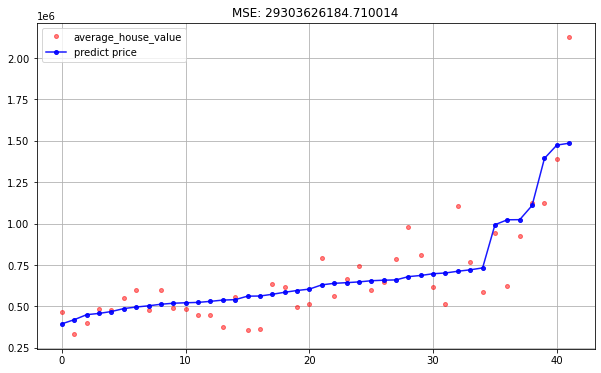

In [27]:
# RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=clf.best_params_["n_estimators"],
    criterion="mse",
    max_depth=clf.best_params_["max_depth"],
    min_samples_leaf=clf.best_params_["min_samples_leaf"],
    n_jobs=2,
    random_state=None,
)

performance_rf = try_different_method(rf)

scores.loc[0, "Random Forest"] = performance_rf[0]
scores.loc[1, "Random Forest"] = performance_rf[1]

<AxesSubplot:title={'center':'variable Importance'}, xlabel='variables'>

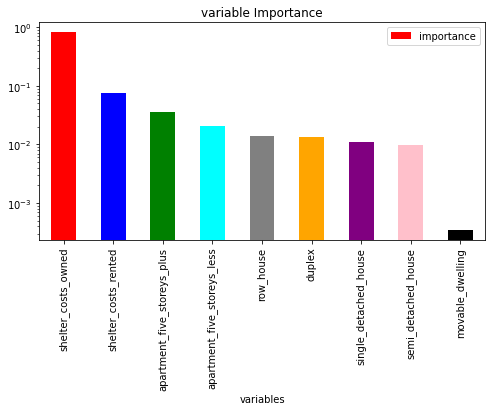

In [28]:
colors = ['red', 'blue', 'green', 'cyan', 'grey', 'orange', 'purple', 'pink', 'black']
importance = pd.DataFrame({"variables": useful_features_1, "importance": rf.feature_importances_})
importance.sort_values(by="importance", axis=0, ascending=False, inplace=True)
importance[:18].plot.bar(
    x="variables",
    y="importance",   
    figsize=(8, 4),
    title="variable Importance",
    logy=True,
    color = colors
)

In [29]:
# parameters to search over with cross-validation
grid_params = [{"max_depth": [3, 4, 5, 6, 8, None], "min_samples_leaf": [1, 2, 5, 7]}]

tree = GridSearchCV(DecisionTreeRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
tree.fit(X_train, y_train)

print("Best parameter values: %r\n" % tree.best_params_)

Best parameter values: {'max_depth': 4, 'min_samples_leaf': 2}



mean_squared_error: 27138021116.419842
r2: 0.744811


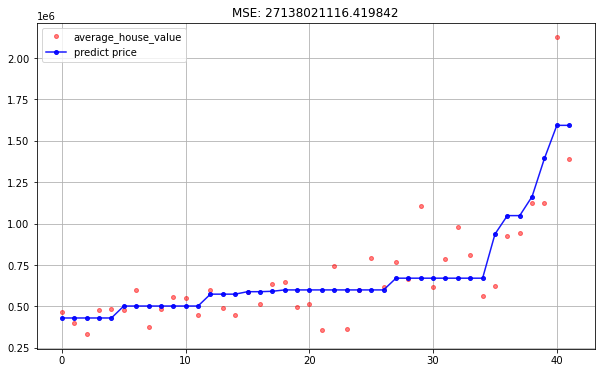

In [30]:
# RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(
    max_depth=tree.best_params_["max_depth"],
    min_samples_leaf=tree.best_params_["min_samples_leaf"],
    random_state=None,
)

performance_tree = try_different_method(tree)
scores.loc[0, "Decistion Tree"] = performance_tree[0]
scores.loc[1, "Decistion Tree"] = performance_tree[1]

## Conclusion

Based on the analysis above using the machine learning methodology, it is proven that the price of the toronto market is going up steadily

the impact is somewhat distorted due to may be inaccurate data, which proves that further cleanup is required,

The analysis could be further confirmed if more vairables were available but due to time shortage we have to work with what was available

Certain programs can be built to fetch data using web scrapping or API like 'foursquare API' to get neighbourhood information like scores of different activites srrounding the neighbouhood, to get better predictability

But overall the above proves that toronto market is going up but at a steady rate